## PyTorch example code for Classifying EEG signals


### Mount the google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Utils

In [ ]:
def count_parameters(model):
  """Function for count model's parameters"""
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

### Import all the packages here

In [ ]:
from scipy import signal
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from torchvision import transforms, utils
import time
from matplotlib import pyplot as plt

# specific package for visualization
!pip install livelossplot --quiet
from livelossplot import PlotLosses

# get the device type of machine
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'

### 1. Data loader

#### Load npy files

In [ ]:
dir = "/content/drive/Shareddrives/EE147/project_data/"

X_test = np.load(dir+"X_test.npy")
y_test = np.load(dir+"y_test.npy")
person_test = np.load(dir+"person_test.npy")

X_train_valid = np.load(dir+"X_train_valid.npy")
y_train_valid = np.load(dir+"y_train_valid.npy")
person_train_valid = np.load(dir+"person_train_valid.npy")

# adjust labels 
y_train_valid -= 769
y_test -= 769
print('y_train_valid', y_train_valid[:10])

y_train_valid [2 3 0 0 0 0 2 1 3 3]


#### Show shape of data

In [ ]:
print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))

Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


#### Torch dataloader

In [ ]:
def transform(X, y, augment=True):
  return X, y

In [ ]:
def load_tensors():
  global X_train_valid_tensor
  global dataloaders

  # Calculate random index splits for train/valid
  N = X_train_valid.shape[0]
  shuffle = np.random.permutation(N)
  train_size = 80 * len(shuffle) // 100
  train_shuffle = shuffle[:train_size]
  valid_shuffle = shuffle[train_size:]

  # Extract splits
  X_train = X_train_valid[train_shuffle]
  y_train = y_train_valid[train_shuffle]
  X_valid = X_train_valid[valid_shuffle]
  y_valid = y_train_valid[valid_shuffle]
  
  print("Original X/y Train", X_train.shape, y_train.shape)
  print("Original X/y Valid", X_valid.shape, y_valid.shape)
  X_train, y_train = transform(X_train, y_train, augment=True)
  X_valid, y_valid = transform(X_valid, y_valid, augment=False)
  print("Transformed X/y Train", X_train.shape, y_train.shape)
  print("Transformed X/y Valid", X_valid.shape, y_valid.shape)

  # copy numpy data to tensor
  X_train_tensor = torch.from_numpy(X_train).float().to(device).permute(0, 2, 1).contiguous()
  y_train_tensor = torch.from_numpy(y_train).float().long().to(device) # do not forget .long()
  X_valid_tensor = torch.from_numpy(X_valid).float().to(device).permute(0, 2, 1).contiguous()
  y_valid_tensor = torch.from_numpy(y_valid).float().long().to(device) # do not forget .long()

  # pdb.set_trace()
  # # convert int labels to one hot labels
  # y_train_valid_tensor = nn.functional.one_hot(y_train_valid_tensor)
  # print('y_train_valid_onehot', y_train_valid_tensor[:10])

  class EEGDataset(Dataset):
      """EEG dataset."""
      def __init__(self, subset, transform=None):
          self.subset = subset
          self.transform = transform
          
      def __getitem__(self, index):
          x, y = self.subset[index]
          if self.transform:
            pass 
              # x = self.transform(x)
              # y = self.transform(y)
          return x, y
          
      def __len__(self):
          return len(self.subset)

  # henX = X_train_valid_tensor.permute(0, 2, 1).contiguous()
  # init_dataset = TensorDataset(henX, y_train_valid_tensor) 

  # split train and val
  # lengths = [int(len(init_dataset)*0.8), int(len(init_dataset)*0.2)] 
  # subset_train, subset_val = random_split(init_dataset, lengths)

  subset_train = TensorDataset(X_train_tensor, y_train_tensor)
  subset_valid = TensorDataset(X_valid_tensor, y_valid_tensor)

  train_data = EEGDataset(
      subset_train, transform=None)

  val_data = EEGDataset(
      subset_valid, transform=None)

  dataloaders = {
      'train': torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True, num_workers=0),
      'val': torch.utils.data.DataLoader(val_data, batch_size=8, shuffle=False, num_workers=0)
  }
load_tensors()

### 3. Train scripts

#### Train function

In [ ]:
def train_model(model, optimizer, num_epochs, sched=None):
    # for each epoch... 
    liveloss = PlotLosses()

    epoch_durations = []
    epoch_forward_durations = []
    for epoch in range(num_epochs):
      print('Epoch {}/{} @ {:1f}/{:1f}s +- {:2f}/{:2f}s'.format(
          epoch, num_epochs - 1,
          np.mean(epoch_forward_durations), np.mean(epoch_durations),
          np.std(epoch_forward_durations), np.std(epoch_durations)))
      print('-' * 10)
      logs = {}
      sched.step() if sched is not None else None

      # let every epoch go through one training cycle and one validation cycle
      # TRAINING AND THEN VALIDATION LOOP...
      epoch_start_time = time.time()
      epoch_forwards = 0.0
      for phase in ['train', 'val']:
        train_loss = 0
        correct = 0
        total = 0
        batch_idx = 0

        start_time = time.time()
        # first loop is training, second loop through is validation
        # this conditional section picks out either a train mode or validation mode
        # depending on where we are in the overall training process
        # SELECT PROPER MODE- train or val
        if phase == 'train':
          for param_group in optimizer.param_groups:
            print("LR", param_group['lr']) # print out the learning rate
          model.train()  # Set model to training mode
        else:
          model.eval()   # Set model to evaluate mode
        
        for inputs, labels in dataloaders[phase]:
          load_time = time.time()
          inputs = inputs.to(device)
          labels = labels.to(device)
          batch_idx += 1
          
          optimizer.zero_grad()
          
          with torch.set_grad_enabled(phase == 'train'):
          #    the above line says to disable gradient tracking for validation
          #    which makes sense since the model is in evluation mode and we 
          #    don't want to track gradients for validation)
            output_final, output_all = model(inputs)
            
            # Within training passes, accumulate time from loading data onto GPU to forward
            if phase == 'train':
              epoch_forwards += time.time() - load_time

            # compute loss where the loss function will be defined later
            loss = loss_fn(output_all[-20:], labels)
            # backward + optimize only if in training phase
            if phase == 'train':
              loss.backward()
              optimizer.step()
            train_loss += loss
            _, predicted = output_final.max(1)

            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        # if phase == 'train':
        #   if  epoch%5 == 0:
        #   # prints for training and then validation (since the network will be in either train or eval mode at this point) 
        #     print(" Training Epoch %d, Total loss %0.6f, iteration time %0.6f" % (epoch, train_loss, time.time() - start_time))

        # if phase == 'val' and epoch%5 == 0:
        #   print(" Validation Epoch %d, Total loss %0.6f, iteration time %0.6f" % (epoch, train_loss, time.time() - start_time))

        if phase == "train":
          epoch_end_time = time.time()
          epoch_durations.append(epoch_end_time - epoch_start_time)
          epoch_forward_durations.append(epoch_forwards)

        prefix = ''
        if phase == 'val':
            prefix = 'val_'
        
        logs[prefix + 'loss'] = train_loss.item()/(batch_idx)
        logs[prefix + 'acc'] = correct/total*100.

      liveloss.update(logs)
      liveloss.send()

    # end of single epoch iteration... repeat of n epochs  
    return model

#### Main 

In [ ]:
# Define a new transformation of train and validation datasets
# Do not augment validation data
# Call load_tensors() to recreate Pytorch tensors using new transform() method.
def transform(X, y, augment=True):
  seq_len = 120
  downsamples = signal.resample(X, seq_len, axis=2)
  cropped = X[:,:,:seq_len]
  combined = np.concatenate([cropped, downsamples], axis=1)
  # print(downsamples.shape, cropped.shape, combined.shape)
  
  augment = False
  if not augment:
    X_transformed = combined[:,:,:-5]
    y_transformed = y
  else:
    augmented = []
    for sample in combined:
      augmented.append(sample[:,:-5])
      augmented.append(sample[:,1:-4])
      augmented.append(sample[:,2:-3])
      augmented.append(sample[:,3:-2])
      augmented.append(sample[:,4:-1])
    X_transformed = np.array(augmented)
    y_transformed = np.repeat(y, 5)
  return X_transformed, y_transformed
# def transform(X, y, augment=True):
#   return X, y
load_tensors()

Original X/y Train (1692, 22, 1000) (1692,)
Original X/y Valid (423, 22, 1000) (423,)
Transformed X/y Train (1692, 44, 115) (1692,)
Transformed X/y Valid (423, 44, 115) (423,)


In [ ]:
class BasicRNN(nn.Module):
  def __init__(self, in_channels, state_size, classes, num_layers=1, dropout=0):
    super(BasicRNN, self).__init__()
    self.rnn = nn.RNN(input_size=in_channels, 
                       hidden_size=state_size,
                       num_layers=num_layers, 
                       dropout=dropout)
    # Output = (T, B, State)

    # self.conv = nn.Conv1d(in_channels=32, out_channels=40, kernel_size=(3,1))
    self.conv = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3,1))
    self.maxpool = nn.MaxPool2d(kernel_size=(3,1), stride=(3,1))
    self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3,1))
    # self.rnn = nn.GRU(input_size=in_channels, 
    #                   hidden_size=state_size,
    #                   num_layers=num_layers,
    #                   dropout=dropout)
    self.fc = nn.Linear(32*12, classes)
    # self.fc2 = nn.Linear(40, classes)

  def forward(self, x):
    # Reshape from (batch, channels, seq) -> (seq, batch, channels)
    x = torch.movedim(x, 1, 0)
    x = x[:70]

    # Pass through RNN (currently a 2-layer LSTM)
    out, h_n = self.rnn(x)
    # out: (T, B, State)

    out = out.permute(1, 2, 0)
    # print("Permuted", out.shape)
    # out: (B, State, T)
    B, State, T = out.shape
    out = out.view(B, 1, State, T)
    # print("View", out.shape)

    # print("Conv2D Input", out.shape)
    out = self.conv(out)
    # print("Conv2D-1 Output", out.shape)
    out = self.maxpool(out)
    # print("MaxPool Output", out.shape)
    out = self.conv2(out)
    # print("Conv2D-2 Output", out.shape)
    # Conv2D-2 Output torch.Size([32, 32, 12, 90])

    out = out.permute(3, 0, 1, 2)
    out = out.view(T, -1, 32*12)
    # Pass final hidden state through FC
    out = self.fc(out)
    # out = self.fc2(out)
    
    return out[-1], out


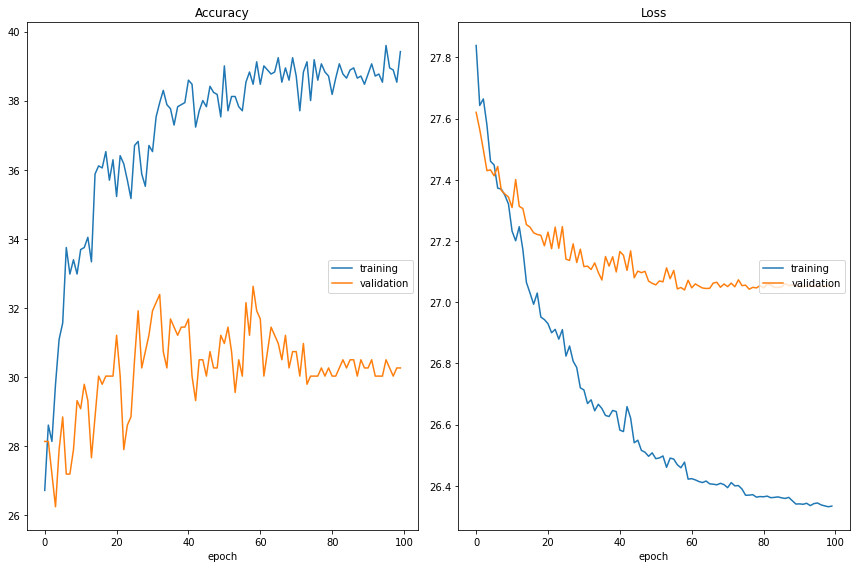

Accuracy
	training         	 (min:   26.714, max:   39.598, cur:   39.421)
	validation       	 (min:   26.241, max:   32.624, cur:   30.260)
Loss
	training         	 (min:   26.332, max:   27.839, cur:   26.333)
	validation       	 (min:   27.040, max:   27.621, cur:   27.050)


In [ ]:
# For lstm-1/2layer: state_size=50

model = BasicRNN(in_channels=44, state_size=44, num_layers=1, classes=4, dropout=0.5).to(device)

count = count_parameters(model)
print ('model parameters amount {}'.format(count))

def loss_fn(outputs, labels):
  single_fn = nn.CrossEntropyLoss()
  loss = 0.0
  for seq in outputs[-30:]:
    loss += single_fn(seq, labels)
  # loss += 1 * single_fn(outputs[-1], labels)
  return loss
# loss_fn = nn.CrossEntropyLoss()

# optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)
optimizer = torch.optim.SGD(model.parameters(), lr=3e-4, momentum=0.9) #, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.5)
model = train_model(model, optimizer, num_epochs=100, sched=scheduler)

---

In [ ]:
N, C, T = X_train_valid.shape
n = np.random.randint(N)
c = np.random.randint(C)
sample = X_train_valid[n,c,:]
downsamples = signal.resample(X_train_valid, 100, axis=2)
downsampled = downsamples[n,c,:]

# seq_len = 150
# X_test = signal.resample(X_test, seq_len, axis=2)
# X_train_valid = signal.resample(X_train_valid, seq_len, axis=2)

plt.plot(np.linspace(0, 1000, num=1000), sample)
plt.plot(np.linspace(0, 1000, num=100), downsampled)
plt.figure()

spectrum = np.fft.fft(sample)
plt.plot(np.linspace(0, 100, num=100), spectrum[:100])
spectrum2 = np.fft.fft(downsampled)
plt.plot(np.linspace(0, 100, num=100), 5*spectrum2)